<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Симуляция-обменных-курсов" data-toc-modified-id="Симуляция-обменных-курсов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Симуляция обменных курсов</a></span></li><li><span><a href="#Модель-обменного-курса" data-toc-modified-id="Модель-обменного-курса-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель обменного курса</a></span></li><li><span><a href="#Task-2:-Range-Accural" data-toc-modified-id="Task-2:-Range-Accural-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Task 2: Range Accural</a></span></li></ul></div>

Выполнили:
- Скворцов Иван
- Каримова Светлана
- Юшков Михаил
- Гончаров Михаил
- Гаршин Сергей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

Задание первого проекта состоит из 2 задач:
1. Создать модель для симуляции 3 скоррелированных между собой риск-факторов:
  - Мгновенная процентная ставка для валюты Рубль
  - Мгновенная процентная ставка для валюты Доллар США
  - Обменный курс Рубль-Доллар

  Для симуляции процентных ставок использовать модель Кокса-Ингерсолла-Росса (CIR)
  - $dX_t=a(b-X_t)dt + \sigma\sqrt{X_t} dW_t$
  - $2ab \geqslant c^2$

  Для симуляции обменного курса использовать логарифмическую модель с лекции от 26.11.2022

  Симуляции провести для расчетной даты 10.12.2021

  Выбор шага симуляции и количества симуляций обосновать (используя 2 задачу проекта)

2. На основании симуляций динамики процентной ставки для рубля оценить справедливую стоимость для продукта Range Accrual

  Для прайсинга необходимо создать отдельный модуль, который будет принимать на вход список параметров продукта:
  - Верхняя граница диапазона (или ее отсутствие)
  - Нижняя граница диапазона (или ее отсутствие)
  - Номинал сделки (максимальную выплату, доступную в случае нахождения внутри диапазона в течение всего срока жизни сделки)
  - Дата начала действия контракта
  - Дата оцончания действия контракта

  Модуль прайсинга вызывает модель симуляции процентной ставки и принимает обратно симуляции с началом в дату начала действия контракта (для простоты считаем, что расчеты проводим в динь заключения). В качестве результата выдаем справедливую стоимость дериватива


---


*Range Accrual — это структурированный продукт, основанный на базовом индексе, доходность которого максимальна, если индекс остается в пределах диапазона, определенного инвестором.*

*По-русски (гоблинский перевод): это бумага с базой (в нашем случае) на мгновенную ставку рубля. Если мы купили бумагу за 10 рублей, договорились, что в течение недели ставкарубля будет 7-8%, и к концу недели ставка не выходила за этот коридор - мы получаем 20 рублей. Если ставка в один из моментов в течение недели вышла - бумага сгорает, затраты не оправданы, выигрыш не получаем. Предсказать нам надо как раз эти 20 рублей (бумага торгуется на рынке, мы купили ее в начале недели по рыночной цене 10 рублей, а в конце недели мы хз сколько она на самом деле будет стоить - это нам и надо предсказать*

[почитать подробнее](https://cbonds.ru/glossary/range-accrual/)

[можно отсуда посмотреть пример кода для моделирования цены RA](https://github.com/SupertallAndy/derivative-pricing/blob/master/range%20accrue.py)

# Данные

- RUONIA https://www.cbr.ru/hd_base/ruonia/dynamics/
- SOFR https://www.newyorkfed.org/markets/reference-rates/sofr

- LIBOR https://www.macrotrends.net/1433/historical-libor-rates-chart
- MOSPRIME http://mosprime.com/archive?date_from=2022-01-01&date_to=2022-12-16&contributor=
- FFR https://www.macrotrends.net/2015/fed-funds-rate-historical-chart
- Курс валют https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.01.2022&UniDbQuery.To=17.12.2022

In [2]:
#!wget -O ffr.csv https://www.dropbox.com/s/qvm6qxtm9q9fwza/fed-funds-rate-historical-chart.csv?dl=1

In [3]:
!wget -O ruonia.csv https://www.dropbox.com/s/2r36i025p8s10v3/ruonia.csv?dl=1

--2022-12-18 18:43:16--  https://www.dropbox.com/s/2r36i025p8s10v3/ruonia.csv?dl=1
Resolving www.dropbox.com... 162.125.66.18
Connecting to www.dropbox.com|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/2r36i025p8s10v3/ruonia.csv [following]
--2022-12-18 18:43:16--  https://www.dropbox.com/s/dl/2r36i025p8s10v3/ruonia.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17a31cf36bb19c523d2bf4820d.dl.dropboxusercontent.com/cd/0/get/By3nb8ctqVw7KZb8az-NBRywx7WnQgmEmEBNQxLUWGtWyssVwk5anGZN-OxRh8nWx9hv69l6T7yMjlPi5sFF2sDOHNghsimhAHhURT3ZkCR5S0EpCJNpE_jENSnshX-AjGETqJkQa9vcW-5RVuokxOQPITzk7wnnjOQbMezkcQ7uFwCAAg_TpEshYZr8mLdyTfQ/file?dl=1# [following]
--2022-12-18 18:43:17--  https://uc17a31cf36bb19c523d2bf4820d.dl.dropboxusercontent.com/cd/0/get/By3nb8ctqVw7KZb8az-NBRywx7WnQgmEmEBNQxLUWGtWyssVwk5anGZN-OxRh8nWx9hv69l6T7yMjlPi5sFF2sDOHNghsimhAHhURT3ZkCR5S0EpCJNpE_jENSnsh

In [4]:
!wget -O usd_rub.csv https://www.dropbox.com/s/aqtfwyedrw2doxe/exchange_rate.csv?dl=1

--2022-12-18 18:43:18--  https://www.dropbox.com/s/aqtfwyedrw2doxe/exchange_rate.csv?dl=1
Resolving www.dropbox.com... 162.125.66.18
Connecting to www.dropbox.com|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/aqtfwyedrw2doxe/exchange_rate.csv [following]
--2022-12-18 18:43:18--  https://www.dropbox.com/s/dl/aqtfwyedrw2doxe/exchange_rate.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc45338d3379322c535cbbb66c5.dl.dropboxusercontent.com/cd/0/get/By20Ih-lbOrQBTHHebGrmx5lKe0iwt5w3fbEXtBE6sNzzhFxI6YD9PrvsH6a3nfrHdrrQUavy4sQP-kPR_tLWa4t3-aIH8kEsKpGo5Ls4Lu50hmhvngVVnA8nvdXtayNYttgrYyXX9ZiM5VcmZLBtRDGyc_t4wn9YNagOQxW3UpLXWnArhbaBFlFFbkV9LyHZJA/file?dl=1# [following]
--2022-12-18 18:43:19--  https://ucc45338d3379322c535cbbb66c5.dl.dropboxusercontent.com/cd/0/get/By20Ih-lbOrQBTHHebGrmx5lKe0iwt5w3fbEXtBE6sNzzhFxI6YD9PrvsH6a3nfrHdrrQUavy4sQP-kPR_tLWa4t3-aIH8kEsKpGo5Ls

In [5]:
!wget -O libor.csv https://www.dropbox.com/s/fb4rlxv2jvv9sse/libor.csv?dl=1

--2022-12-18 18:43:19--  https://www.dropbox.com/s/fb4rlxv2jvv9sse/libor.csv?dl=1
Resolving www.dropbox.com... 162.125.66.18
Connecting to www.dropbox.com|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/fb4rlxv2jvv9sse/libor.csv [following]
--2022-12-18 18:43:20--  https://www.dropbox.com/s/dl/fb4rlxv2jvv9sse/libor.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f5548e64b8cc0497392b1ff00.dl.dropboxusercontent.com/cd/0/get/By3VzVzM0lQtbNeCgcAltTUKMbbnQd6_GAOCGJI05g-HprlFuXJstkOnn2FSTsgz9ma5PX6NKmMvSEjSju0EN8ntCPGtdfGBTSiEfOonku0Sw5FUE37TH8RfwejsoHcZolKeTbNZMaBvzn4EJKRdGV3rr3i27Cbru-0ryGo8KY7AaooEI_aH4APCvlrdT5_vi2Y/file?dl=1# [following]
--2022-12-18 18:43:20--  https://uc1f5548e64b8cc0497392b1ff00.dl.dropboxusercontent.com/cd/0/get/By3VzVzM0lQtbNeCgcAltTUKMbbnQd6_GAOCGJI05g-HprlFuXJstkOnn2FSTsgz9ma5PX6NKmMvSEjSju0EN8ntCPGtdfGBTSiEfOonku0Sw5FUE37TH8RfwejsoHcZ

In [6]:
ffr = pd.read_csv(
    'libor.csv'
    )[['date', ' value']].rename(columns={' value' : 'ffr'})

ffr['date'] = pd.to_datetime(ffr['date'])

idx = pd.date_range('2015-01-01', '2022-12-20')
ffr.index = pd.DatetimeIndex(ffr.date)

ffr = ffr.reindex(idx)[['ffr']]
ffr['ffr'] = ffr['ffr'].fillna(method='ffill')

In [7]:
ruonia = pd.read_csv(
    'ruonia.csv',
    sep=';'
    )[['date', 'ruonia']]

ruonia['ruonia'] = ruonia['ruonia'].str.replace(',', '.').astype(np.float64)

ruonia['date'] = pd.to_datetime(ruonia['date'], format='%d.%m.%Y')

idx = pd.date_range('2015-01-01', '2022-12-20')
ruonia.index = pd.DatetimeIndex(ruonia.date)

ruonia = ruonia.reindex(idx)[['ruonia']]
ruonia['ruonia'] = ruonia['ruonia'].fillna(method='ffill')

In [8]:
rates = ruonia.join(ffr).dropna()

<AxesSubplot:xlabel='ruonia', ylabel='ffr'>

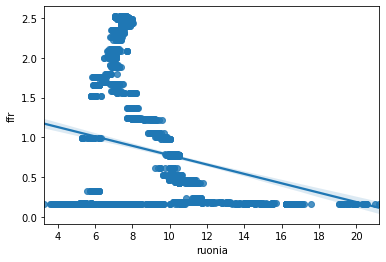

In [9]:
sns.regplot(data=rates, x='ruonia', y='ffr')

In [10]:
fx = pd.read_csv(
    'usd_rub.csv',
    sep=';'
    )

fx['fx'] = fx['fx'].str.replace(',', '.').astype(np.float64)

fx['date'] = pd.to_datetime(fx['date'], format='%d.%m.%Y')
#fx = fx[fx.date >= '2022-01-01']

idx = pd.date_range('2015-01-01', '2022-12-20')
fx.index = pd.DatetimeIndex(fx.date)

fx = fx.reindex(idx)[['fx']]
fx['fx'] = fx['fx'].fillna(method='ffill')

In [11]:
data = rates.join(fx).dropna()

In [12]:
data = data[data.index<'2022-01-01']

In [13]:
corr_matrix = data.diff().dropna().corr()

In [14]:
values_10_12_2021 = {
    'rub' : 7.45,
    'usd' : 0.08,
    'fx'  : 73.5998
}

# Симуляция обменных курсов

Модель процентной ставки:

  - $dX_t=a(b-X_t)dt + \sigma\sqrt{X_t} dW_t$
  - $2ab \geqslant c^2$

Дискретизация модели:
  $$
X_{t_{i+1}} - X_{t_i} = a(b-X_{t_i}) \Delta t + \sigma \sqrt{|X_{t_i}|} \sqrt{\Delta t} Z_i,
  $$

где $Z_i \sim_{iid} \mathcal{N}(0,1)$. Абсолютное значение $X$ берется с учетом возможных ошибок дискретизации (симуляцию может завести не туда, хоть CIR процесс и положительный).

Оценивать параметры для динамики процентных ставок будем при помощи МНК.

$$
\begin{aligned}
 & \frac{X_{t_{i+1}} - X_{t_i}}{\sqrt{|X_{t_i}|}} = ab\frac{\Delta t}{\sqrt{|X_{t_i}|}} - a\sqrt{|X_{t_i}|} \Delta t + \sigma\sqrt{\Delta t} Z_i \\
& y_i = \frac{X_{t_{i+1}} - X_{t_i}}{\sqrt{|X_{t_i}|}} \\
& \beta_1 = ab \\
& \beta_2 = -a \\
& x_{1i} = \frac{\Delta t}{\sqrt{|X_{t_i}|}} \\
& x_{2i} = \sqrt{|X_{t_i}|} \Delta t \\
& \varepsilon_i = \sigma\sqrt{\Delta t} Z_i
\end{aligned}
$$

In [15]:
def estimate_cir_params(s: pd.Series):
  '''
  Функция для оценки параметров CIR-модели.
  '''
    delta_t = 1
    reg_data = pd.DataFrame(s)
    reg_data['delta_X'] = s.diff().shift(-1)
    reg_data['x_1'] = delta_t / np.sqrt(np.abs(s))
    reg_data['x_2'] = np.sqrt(np.abs(s)) * delta_t
    reg_data['y'] = reg_data['delta_X'] / np.sqrt(np.abs(s))
    reg_data.dropna(inplace=True)

    linreg = LinearRegression(fit_intercept=False).fit(reg_data[['x_1', 'x_2']], reg_data['y'])
    beta_1, beta_2 = linreg.coef_
    std_epsilon = np.sqrt(np.square(reg_data['y'] - linreg.predict(reg_data[['x_1', 'x_2']])).sum()) / np.sqrt(reg_data.shape[0])
  
    sigma = std_epsilon / np.sqrt(delta_t)
    a = - beta_2
    b = beta_1 / a

    return a, b, sigma

In [16]:
a_rub, b_rub, sigma_rub = estimate_cir_params(data.ruonia)
a_usd, b_usd, sigma_usd = estimate_cir_params(data.ffr)

In [17]:
def generate_CIR_process(N, X_0, a, b, sigma, sample_size, dW=None):
  '''
  Функция для генерации CIR.
  Код говорит сам за себя.
  '''
    if dW is None:
        dW = sigma * np.random.normal(size=(sample_size, N))
    else:
        dW = sigma * dW
    
    CIR = np.zeros((sample_size, N))
    CIR[:, 0] = X_0
    for i in range(1, CIR.shape[1]):
        X_prev = CIR[:, i-1]
        mean_convergence_component = a * (b - X_prev)
        stochastic_component = dW[:, i] * np.sqrt(np.abs(X_prev))
        
        CIR[:, i] += X_prev + mean_convergence_component + stochastic_component
    
    return CIR

In [18]:
def plot_results(sim, title, ylim=None):
  '''
  Помогает рисовать графики
  '''
    fig, ax = plt.subplots(1, figsize=(15,10))
    for row in sim:
        ax.plot(row, alpha=0.3, color='gray', lw=.5)
    ax.plot(sim.mean(axis=0), label='Среднее', color='salmon', lw=5)
    ax.set(title=title, xlabel='Дни', ylabel='Значения')
    ax.legend()

    if ylim is not None:
        plt.ylim(ylim)

    plt.show()

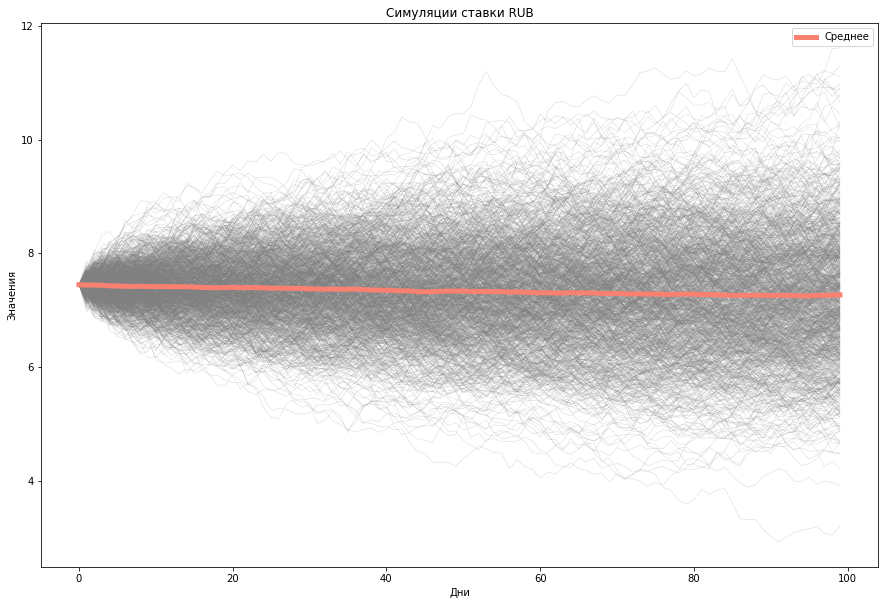

In [19]:
R_rub = generate_CIR_process(100, values_10_12_2021['rub'], a_rub, b_rub, sigma_rub, 1000)
plot_results(R_rub, title='Симуляции ставки RUB')

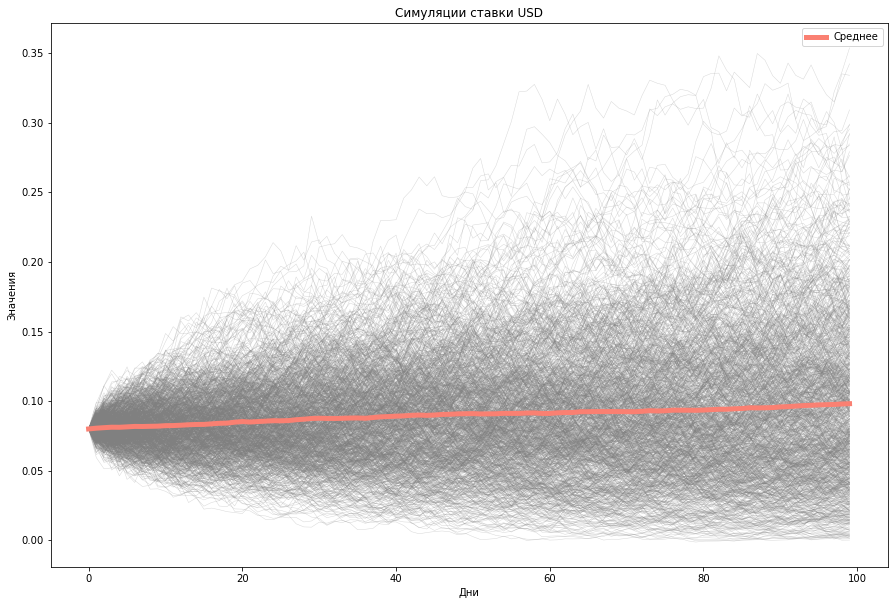

In [20]:
R_usd = generate_CIR_process(100, values_10_12_2021['usd'], a_usd, b_usd, sigma_usd, 1000)
plot_results(R_usd, title='Симуляции ставки USD')

Теперь обеспечим скоррелированность стохастических компонент наших процессов. Эти компоненты потом будем подавать в генераторы CIR и модели обменного курса.

In [21]:
def generate_correlated_dW(N, sample_size, corr_matrix):
  '''
  Тут все тоже понятно.
  '''
    cholesky = np.linalg.cholesky(corr_matrix)
    non_correlated_dw = np.array([np.random.normal(size=(sample_size, N)) for _ in range(3)])
    non_correlated_dw = np.transpose(non_correlated_dw, (1,0,2))
    correlated_dw = np.dot(cholesky, non_correlated_dw)
    
    return correlated_dw

# Модель обменного курса

Ставки генерировать умеем, осталось реализовать модель обменного курса. 

$$
\frac{dX_t}{X_t} = [r_f (t) - r_d (t) + \lambda]dt + \sigma dW_t
$$

$$
X_{t_{i+1}} - X_{t_i} = X_{t_i}[r_f (t_i) - r_d (t_i) + \lambda]\Delta t + \sigma X_{t_i} \sqrt{\Delta t}Z_i
$$

С помощью МНК нужно оценить два параметра &mdash; $\lambda$ и $\sigma$.
$$
\frac{X_{t_{i+1}} - X_{t_i}}{X_{t_i}} - [r_f (t_i) - r_d (t_i)]\Delta t = \lambda \Delta t + \sigma\sqrt{\Delta t}Z_i,
$$
где $\beta = \lambda \Delta t$ и $\varepsilon_i = \sigma\sqrt{\Delta t}Z_i$.

In [22]:
def estimate_fx_params(df: pd.DataFrame):
  '''
  Функция для оценки параметров модели обменного курса.
  '''
    delta_t = 1
    reg_data = df.copy()
    reg_data['delta_X'] = df['fx'].diff().shift(-1)
    reg_data['y'] = (reg_data['delta_X'] / reg_data['fx']) - (reg_data['ffr']/100 - reg_data['ruonia']/100) * delta_t
    reg_data['x_1'] = np.ones(reg_data.shape[0])
    reg_data.dropna(inplace=True)

    linreg = LinearRegression(fit_intercept=False).fit(reg_data[['x_1']], reg_data['y'])
    beta = linreg.coef_[0]
    std_epsilon = np.sqrt(np.square(reg_data['y'] - linreg.predict(reg_data[['x_1']])).sum()) / np.sqrt(reg_data.shape[0])

    sigma = std_epsilon / np.sqrt(delta_t)
    lambda_ = beta / delta_t

    return lambda_, sigma

In [23]:
lambda_fx, sigma_fx = estimate_fx_params(data)

In [24]:
def generate_FX_process(X_0, lambda_, sigma, foreign, domestic, dW=None):
    if dW is None:
        dW = np.random.normal(size=foreign.shape)
    else:
        dW = sigma * dW

    FX = np.zeros_like(foreign)
    FX[:, 0] = X_0
    for i in range(1, FX.shape[1]):
        X_prev = FX[:, i-1]
        foreign_prev = foreign[:, i-1]
        domestic_prev = domestic[:, i-1]
        rate_component = X_prev * (foreign_prev/100 - domestic_prev/100 + lambda_)
        stochastic_component = X_prev * dW[:, i]

        FX[:, i] += X_prev + rate_component + stochastic_component

    return FX

In [25]:
dW_correlated = generate_correlated_dW(100, 1000, corr_matrix)

R_rub = generate_CIR_process(100, values_10_12_2021['rub'], a_rub, b_rub, sigma_rub, 1000, dW_correlated[0])
R_usd = generate_CIR_process(100, values_10_12_2021['usd'], a_usd, b_usd, sigma_usd, 1000, dW_correlated[1])
R_fx = generate_FX_process(values_10_12_2021['fx'], lambda_fx, sigma_fx, R_usd, R_rub, dW_correlated[2])

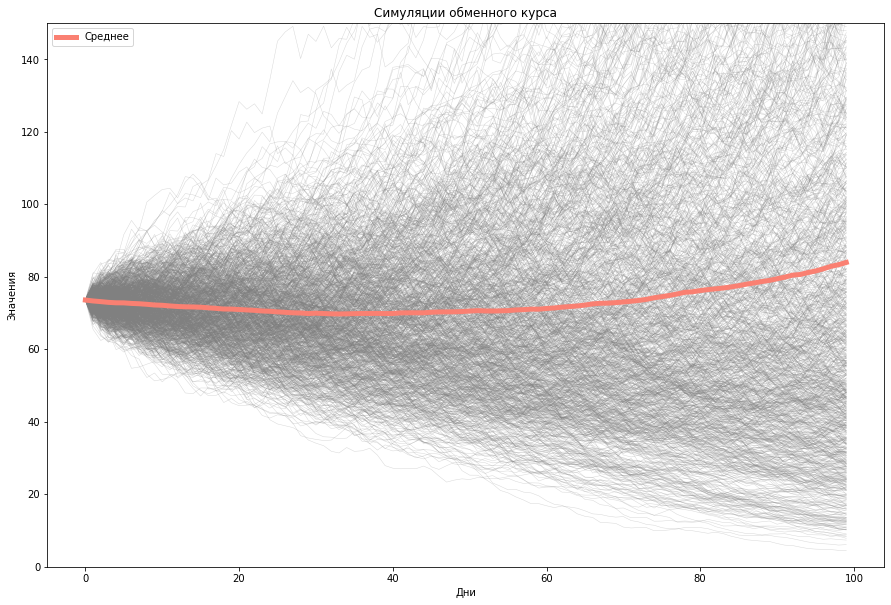

In [26]:
plot_results(R_fx, title='Симуляции обменного курса', ylim=[0,150])

# Task 2: Range Accural

In [27]:
# discounting is not considered 
# derivative's fair price = average among the trajectories

import datetime
from typing import Optional


class PricingRangeAccural: 
    def __init__(self, 
                 denomination: float, 
                 start_date: datetime, 
                 end_date: datetime, 
                 upper_bound: Optional[float] = None,
                 lower_bound: Optional[float] = None
                 ):
        self.denomination = denomination
        self.start_date = start_date 
        self.end_date = end_date
        self.upper_bound = upper_bound # bound not inclusive
        self.lower_bound = lower_bound # bound not inclusive

    def calc_fair_value(self, *args_cir_proc): 
        
        # check the correctness of passed dates
        self.check_dates()

        num_days = (self.end_date - self.start_date).days
        R_rub = generate_CIR_process(*args_cir_proc) # траектория это строка 
        assert R_rub.shape[1] >= num_days, f'number of days while generating CIR process' + \
            'should be greater than differnce between end and start date'

        # "для простоты считаем, что расчеты проводим в день заключения контракта"
        # оставляем только те дни, которые идут до end_date
        R_rub = R_rub[:, :num_days] 

        # зададим верхнюю и нижную границу (в случае, если они не даны)
        self.define_borders()

        # calculate the number of days when each of trajectories was inside the boundaries
        num_days_inside_borders = ((R_rub > self.lower_bound) & (R_rub < self.upper_bound)).sum(axis=1)

        # calculate the fair price for each of trajectories 
        self.fair_prices = self.denomination * num_days_inside_borders / num_days 

        return self.fair_prices.mean()
    
    def define_borders(self): 
        # считаем что цена должна находится строго внутри диапазона (не на границе), поэтому +- 1
        if not self.upper_bound: 
            self.upper_bound = R_rub.max() + 1 
        if not self.lower_bound: 
            self.lower_bound = R_rub.min() - 1

    def check_dates(self): 
        base_date = '10.12.2021'
        base_date = datetime.datetime.strptime(base_date, '%d.%m.%Y').date()

        assert isinstance(self.start_date, datetime.date) and isinstance(
            self.end_date, datetime.date), 'dates type should be correct'
        assert self.start_date < self.end_date, f'end date should be later than start date'
        assert self.start_date > base_date, f'start date should later than {base_date}'

In [28]:
# creation of PricingRangeAccural
denomination = 1000
start_date = datetime.datetime.strptime('01.09.2022', '%d.%m.%Y').date()
end_date = datetime.datetime.strptime('01.10.2022', '%d.%m.%Y').date()
upper_bound = 8
lower_bound = 7

pra = PricingRangeAccural(denomination, start_date, end_date, upper_bound, lower_bound)

# fair price evaluation
N = 365
X_0 = values_10_12_2021['rub']
sample_size = 1000
pra.calc_fair_value(N, X_0, a_rub, b_rub, sigma_rub, sample_size)

701.3